# Project 2

## Northwind Traders Database - ERD

<img src='Northwind_ERD.png'>

<i>NOTE -  all table names in the sinular NOT plural

In [1]:
#import basic libraries
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#connect to databse
conn= sqlite3.connect('Northwind_small.sqlite')
cursor=conn.cursor()

In [3]:
#get table names
tables=cursor.execute('''SELECT name FROM sqlite_master WHERE TYPE = "table"''').fetchall()
tables
# note all table names in the SINGULAR
# 'Order' is reserved word in SQL will need to enclose in [] -- [order]

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

### 1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

Begin by viewing the OrderDetail table to ascertain what kinds of discounts are being given and how frequently

In [4]:
# import table from database to pandas dataframe and view head
OD=pd.read_sql('''SELECT * FROM OrderDetail''',conn)
OD.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [5]:
#relevant features - ProductId, Quantity, Discount
OD=OD[['ProductId','Quantity','Discount']]
OD.head()

,ProductId,Quantity,Discount
0,11,12,0.0
1,42,10,0.0
2,72,5,0.0
3,14,9,0.0
4,51,40,0.0


In [6]:
OD.describe()

,ProductId,Quantity,Discount
count,2155.000000,2155.000000,2155.000000
mean,40.793039,23.812993,0.056167
std,22.159019,19.022047,0.083450
min,1.000000,1.000000,0.000000
25%,22.000000,10.000000,0.000000
50%,41.000000,20.000000,0.000000
75%,60.000000,30.000000,0.100000
max,77.000000,130.000000,0.250000


In [7]:
OD.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Products are ordered in quantities ranging form 1 to 130 with discounts from 0.00 (no discount) to 0.25 (25%)

number of orders by product

In [8]:
OD.ProductId.value_counts()

59    54
31    51
24    51
60    51
56    50
62    48
41    47
75    46
2     44
16    43
71    42
40    41
13    40
70    39
76    39
51    39
21    39
72    38
11    38
77    38
1     38
19    37
17    37
54    36
35    36
68    34
55    33
28    33
10    33
29    32
      ..
38    24
57    23
14    22
49    21
47    21
23    20
4     20
34    19
58    18
25    18
63    17
20    16
32    15
12    14
73    14
45    14
22    14
8     13
74    13
3     12
6     12
67    10
50    10
5     10
27     9
66     8
48     6
15     6
37     6
9      5
Name: ProductId, Length: 77, dtype: int64

How are products discounted? Are products always given the same discount level?

In [9]:
OD.loc[OD.ProductId==59]['Discount'].value_counts()

0.00    34
0.05     7
0.15     6
0.20     3
0.10     2
0.25     2
Name: Discount, dtype: int64

NOPE

There are 77 different products, is every product sold with a discount some of the time?

In [10]:
len(OD.loc[OD.Discount>0]['ProductId'].value_counts())

77

YES

Too many different products to examine individually many of which have too few sales for analysis by product.

Analysis by discount level vs non-discounted still viable with discount level with very few orders a binned to 0.05

In [11]:
for i in [0.01,0.02,0.03,0.04,0.06]:
    OD.Discount.replace(to_replace=i,value=0.05,inplace=True)
OD.Discount.value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [12]:
OD.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 ])

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


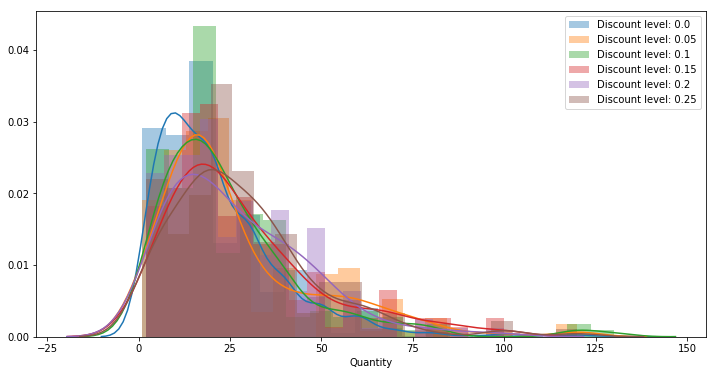

In [33]:
plt.figure(figsize=(12,6))
for i in sorted(OD.Discount.unique()):
    sns.distplot(OD.loc[OD.Discount==i]['Quantity'], label='Discount level: '+str(i), bins =20)
#     plt.legend()
#     plt.show()
plt.legend()

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


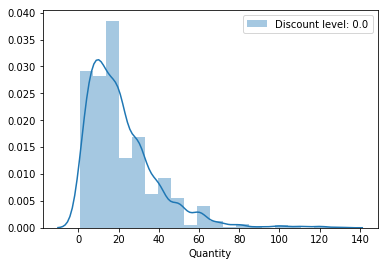

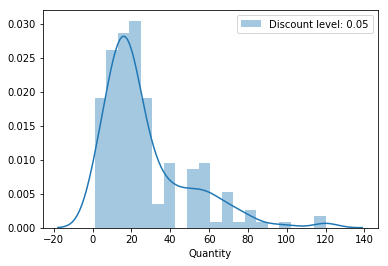

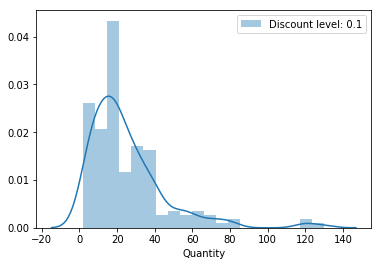

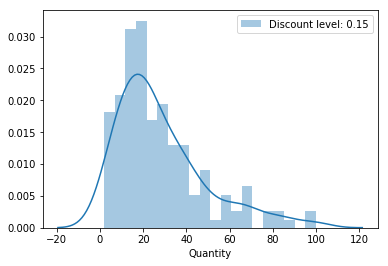

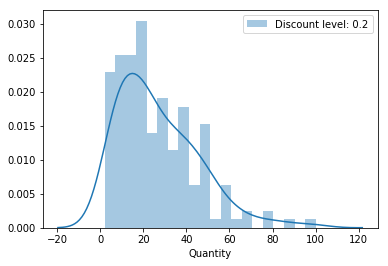

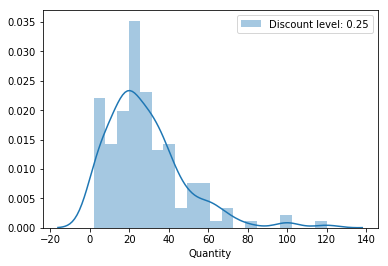

In [34]:
for i in sorted(OD.Discount.unique()):
    sns.distplot(OD.loc[OD.Discount==i]['Quantity'], label='Discount level: '+str(i), bins =20)
    plt.legend()
    plt.show()

Skewed distributions with long tails

Null hyposthesis: no difference in Quantity ordered mean (Qmu) for discount = 0 and any other discount level

H0:  Qmu_discount = mu_nodiscount for each discount level

ALternative hypothesis: discounts result in increased sales volume 

H1:  Qmu_discount > mu_nodiscount for each discount level

To test this hypothesis we will conduct a 2 sample t- test between no discount and each discount level with p value threshold =0.05 to reject the null hypothesis

In [35]:
from scipy import stats

In [36]:
Q_nodiscount=OD.loc[OD.Discount==0]['Quantity']
Q_5pc_discount=OD.loc[OD.Discount==0.05]['Quantity']
Q_10pc_discount=OD.loc[OD.Discount==0.10]['Quantity']
Q_15pc_discount=OD.loc[OD.Discount==0.15]['Quantity']
Q_20pc_discount=OD.loc[OD.Discount==0.20]['Quantity']
Q_25pc_discount=OD.loc[OD.Discount==0.25]['Quantity']

In [ ]:
for disc in [Q_5pc_discount,Q_10pc_discount, Q_15pc_discount, Q_20pc_discount,Q_25pc_discount]:
t_stat, p= stats.ttest(Q_nodiscount,disc,equal_var=False) #Welch's T-test for unequal variance
print()